In [1]:
import pytorch_lightning as pl
import h5py
import os
import torch
import csv
import re
import numpy as np
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import library as lib
import pandas as pd
from matplotlib.pylab import plt
from sklearn.manifold import trustworthiness

import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
pl.seed_everything(42, workers=True) 

Global seed set to 42


42

# Parameters

In [3]:
print(os.getcwd())
work_dir = str(os.getcwd())+"/"
inputs = "./inputs/"
out_path = "./out_dir/"

writer = True
gpu = False

activation_function = "sigmoid"
#exec(f"torch.nn.functional.{get_activation(self)}({self.latent(self.encoder(x))})")

epoch = 1

dim = 2560
dim3 = int(dim * 1/16)
dim2 = int(dim * 1/8)
dim1 = int(dim * 1/2)

/Users/adel.schmucklermann/Desktop/PyTorch_Lightning_VAE


# Data Pre-Processing

In [4]:
#make numpy file with (seq header, embedding)
esm2 = h5py.File(inputs+"KLK_esm2.h5", 'r')
list(esm2.keys())
# List all groups
keys = list(esm2.keys())
#print(keys) 
# Get the data
embedding = []
headers = []
for key in keys:
    #data
    emb = esm2[key][:]
    embedding.append(emb)
    #headers
    key = key.replace("isoform=", "isoform_").replace("=", "").replace(":", "_")
    if key == "GZMA_Canis_lupus":
        print("header is now changed")
        key = "GZMA_Canis_lupus_1"
    headers.append(key)

headers = np.array(headers)
embedding = np.array(embedding)

#split train test
headers_first, headers_test, embedding_first, embedding_test = train_test_split(headers, embedding, test_size=0.1, random_state=42)
#split train validation
headers_train, headers_validate, embedding_train, embedding_validate = train_test_split(headers_first, embedding_first, test_size =0.2, random_state=42)
print("total:", headers.shape)
print("training+validation:", headers_first.shape)
print("test:", headers_test.shape)
print("training:", headers_train.shape)
print("validation:", headers_validate.shape)
print(len(headers_train), len(embedding_train))
print(len(headers_validate), len(embedding_validate))

#training_df = pd.DataFrame({'header': headers_train, 'embedding' : embedding_train})
#validate_df = pd.DataFrame({'header': headers_validate, 'embedding' : embedding_validate})

header is now changed
total: (437,)
training+validation: (393,)
test: (44,)
training: (314,)
validation: (79,)
314 314
79 79


# Dataloaders

In [5]:
train_dataset = lib.makedataset(headers_train, embedding_train)
val_dataset = lib.makedataset(headers_validate, embedding_validate)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0, drop_last=True)
    

# Training VAE

In [6]:
#if prott5 used: dtype=float16 -> error with .linear()

#encoder_layers, latent_dim, decoder_layers


encoder_layers = [dim, dim1, dim2, dim3]
latent_dim = dim3
decoder_layers = [dim3, dim2, dim1, dim]

# Initialize the VAE model
vae = lib.VariationalAutoencoder(encoder_layers, latent_dim, decoder_layers)

if gpu:
    trainer = pl.Trainer(accelerator="gpu", devices = 1, max_epochs=epoch, log_every_n_steps=4, check_val_every_n_epoch=1)
else:
    trainer = pl.Trainer(accelerator="auto", max_epochs=epoch, log_every_n_steps=4, check_val_every_n_epoch=1)

# Train the VAE model
trainer.fit(vae, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adel.schmucklermann/miniconda3/envs/FP_lightning/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 3.7 M 
1 | latent  | Sequential | 26.1 K
2 | fc21    | Linear     | 25.8 K
3 | fc22    | Linear     | 25.8 K
4 | fc3     | Sequential | 26.1 K
5 | f

Sanity Checking: 0it [00:00, ?it/s]

/Users/adel.schmucklermann/miniconda3/envs/FP_lightning/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/adel.schmucklermann/miniconda3/envs/FP_lightning/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/adel.schmucklermann/miniconda3/envs/FP_lightning/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


# Fix Formatting

In [7]:
def find_largest_number(root_dir):
    largest_number = 0
    for subdir, dirs, files in os.walk(root_dir):
        for dir_name in dirs:
            match = re.search(r'\d+', dir_name)
            if match:
                current_number = int(match.group())
                if current_number > largest_number:
                    largest_number = current_number
    return largest_number

largest_num = find_largest_number(work_dir+"lightning_logs")

#Fix formatting
with open(work_dir+'lightning_logs/version_' + str(largest_num) + '/metrics.csv', 'r') as file:
    reader = csv.reader(file)
    rows = list(reader)

combined_rows = []
header_row = ['train_loss','reconstruction_loss','kl_loss','epoch','step','validation_loss']

combined_rows.append(header_row)
for i in range(1, len(rows) -1, 2):
    train_loss = rows[i][0]
    reconstruction_loss = rows[i][1]
    kl_loss = rows[i][2]
    epoch = rows[i+1][3]
    step = rows[i+1][4]
    validation_loss = rows[i+1][5]
    combined_rows.append([train_loss,reconstruction_loss,kl_loss,epoch,step,validation_loss])

with open(work_dir+'lightning_logs/version_' + str(largest_num) + '/new_metrics.csv', 'w', newline = "") as file:
    writer = csv.writer(file)
    writer.writerows(combined_rows)

# Plot Loss

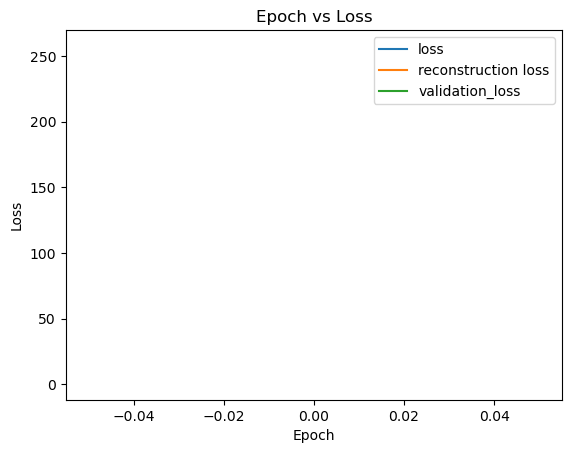

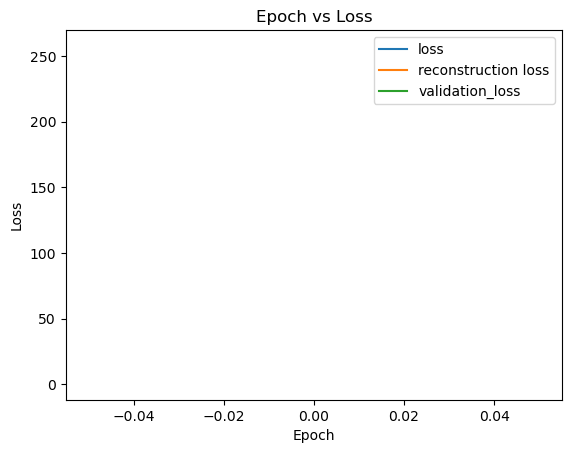

In [8]:
#Plot
# read csv file
df = pd.read_csv('lightning_logs/version_' + str(largest_num) + '/new_metrics.csv')

df1 = df[df['epoch'] >= int(epoch)/2]

# plot 0
plt.plot('epoch', 'train_loss', data=df)
plt.plot('epoch', 'reconstruction_loss', data=df)
plt.plot('epoch', 'validation_loss', data=df)
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'reconstruction loss', 'validation_loss'], loc='upper right')
plt.show()


# plot 1
plt.plot('epoch', 'train_loss', data=df1)
plt.plot('epoch', 'reconstruction_loss', data=df1)
plt.plot('epoch', 'validation_loss', data=df1)
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'reconstruction loss', 'validation_loss'], loc='upper right')
plt.show()

# Encode

In [9]:
encode = vae.encoder(torch.Tensor(embedding))
#mu, logvar = vae.encode(torch.Tensor(embedding))
#en = vae.reparameterize(mu, logvar)
#encode = vae.decode(en)
print(encode)

#encode = encode #[1]




tensor([[0.7289, 0.8060, 0.4339,  ..., 0.3539, 0.4556, 0.3622],
        [0.6907, 0.8985, 0.4067,  ..., 0.2060, 0.4690, 0.2582],
        [0.4051, 0.2875, 0.3208,  ..., 0.5207, 0.4634, 0.6678],
        ...,
        [0.6734, 0.5534, 0.3125,  ..., 0.3785, 0.2711, 0.5596],
        [0.7366, 0.8238, 0.2702,  ..., 0.2716, 0.2660, 0.5545],
        [0.8060, 0.8699, 0.1300,  ..., 0.3080, 0.3510, 0.7744]],
       grad_fn=<SigmoidBackward0>)


# Neighbor joining

euclidean
trustworthiness:  0.9723722892253068


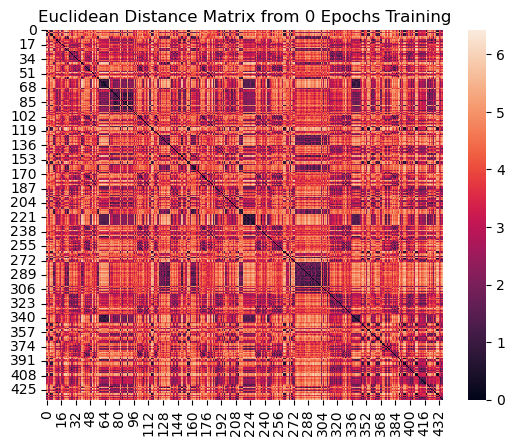

In [10]:
# Neighbor_joining and create tree

#cosine, euclidean, manhattan, ts_ss, jensenshannon
metric_list = ["cosine","euclidean", "manhattan", "ts_ss"]


def nj(metric_list, embedding_out, writer, out_path, epoch, trained,activation_function):
    for metric in metric_list:
        print(metric)

        out_newick = out_path+"KLK_"+activation_function+"_esm2_nj_"+str(epoch)+"_"+metric+trained+".newick"


        #distance metric
        dist = lib.distance_metric(embedding_out)
        distmat = dist.get_metric(embedding_out, metric)

        
        #neighbor joining to tree
        nj = lib.neighbor_joining(distmat,headers)
        newick = nj.get_newick(distmat,headers)

        #trustworthiness
        _distmat  = lib.cophenetic_distmat(newick, names=headers)
        _trustworthiness = trustworthiness(distmat, _distmat, n_neighbors=10, metric='precomputed')
        print("trustworthiness: ", _trustworthiness)


        #silhouette = silhouette_score(_distmat, headers, metric='precomputed')
        #silhouette = lib.silhouette.get_silhouette(distmat, headers)
        #print("silhouette: ", silhouette)

        
        sns.heatmap(distmat).set(title=metric.capitalize()+' Distance Matrix from '+str(epoch)+' Epochs Training')
        #plt.savefig(out_path+'heatmap_training_sig_'+str(epoch)+'_'+metric+dataset+'.png', dpi=400)
        
        if writer:
            with open(out_newick, 'w') as w:
                w.write(newick)
                w.close()
            
embedding_out = encode.detach()            
nj(metric_list[1:2], embedding_out, True, out_path, epoch, "",activation_function)            

# Reference NJ: no training 

euclidean
trustworthiness:  0.9320683730058552


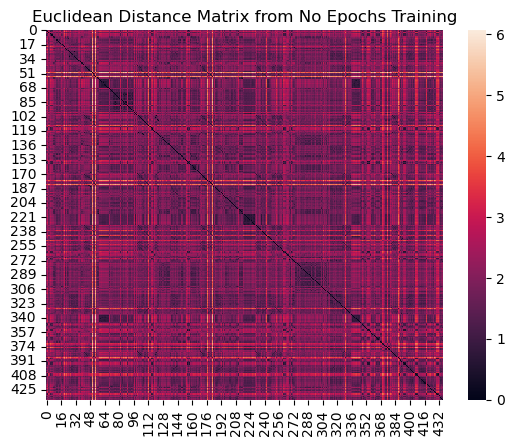

In [11]:
writer = False

metric_list = ["cosine","euclidean", "manhattan", "ts_ss"]

nj(metric_list[1:2], embedding, writer, out_path, "No", "_notraining",activation_function)   


# UPGMA and create tree

epoch: 0
metric: cosine
trustworthiness:  0.9741177173166554


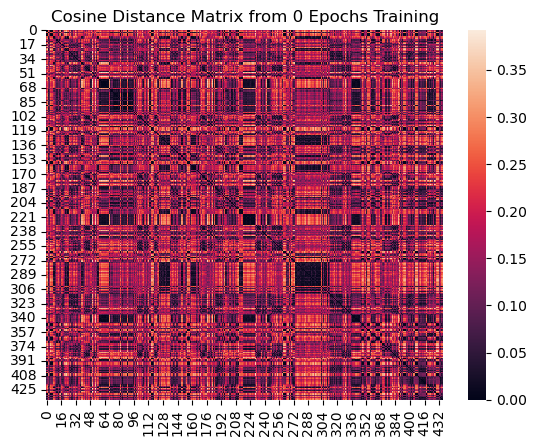

In [12]:
#write output flag
from sklearn.metrics import silhouette_score
from itertools import groupby
import string



metric_list = ["cosine","euclidean", "manhattan", "ts_ss"]

def upgma(metric_list, embedding_out, writer, out_path, epoch, trained ,activation_function):
    
    print("epoch:",epoch)

    for metric in metric_list:
        print("metric:", metric)
        
        out_newick = out_path+"KLK_"+activation_function+"_esm2_upgma_"+str(epoch)+"_"+metric+trained+".newick"

        embedding_out = encode.detach()

        #distance metric
        dist = lib.distance_metric(embedding_out)
        distmat = dist.get_metric(embedding_out, metric)
        #print(distmat)

        #upgma to tree
        upgma = lib.upgma(distmat,headers)

        #trustworthiness
        _distmat  = lib.cophenetic_distmat(upgma, names=headers)
        _trustworthiness = trustworthiness(distmat, _distmat, n_neighbors=10, metric='precomputed')
        print("trustworthiness: ", _trustworthiness)

        
        sns.heatmap(distmat).set(title=metric.capitalize()+' Distance Matrix from '+str(epoch)+' Epochs Training')
        #plt.savefig(out_path+'heatmap_training_sig_'+str(epoch)+'_'+metric+dataset+'.png', dpi=400)
        
        if writer:
            with open(out_newick, 'w') as w:
                w.write(upgma)
                w.close()
                
upgma(metric_list[0:1], embedding_out, True, out_path, epoch, "",activation_function)


# Reference UPGMA: no training

epoch: No
metric: euclidean
trustworthiness:  0.9727072594064459
[[-0.02332501 -0.02666851 -0.02547389 ...  0.00090483 -0.1859118
  -0.04491666]
 [-0.02159931 -0.02498524 -0.0692937  ... -0.01443925 -0.15112399
  -0.04095096]
 [ 0.00914663  0.04136267 -0.03211368 ...  0.01701118 -0.1324426
  -0.0277246 ]
 ...
 [-0.03922842  0.02484268  0.00240228 ...  0.00773771 -0.17052853
  -0.03448144]
 [-0.05341766  0.01231494 -0.04827601 ... -0.02293118 -0.18059368
   0.00656287]
 [-0.04668897  0.00788071 -0.0160248  ... -0.04795283 -0.15742938
   0.03342032]]


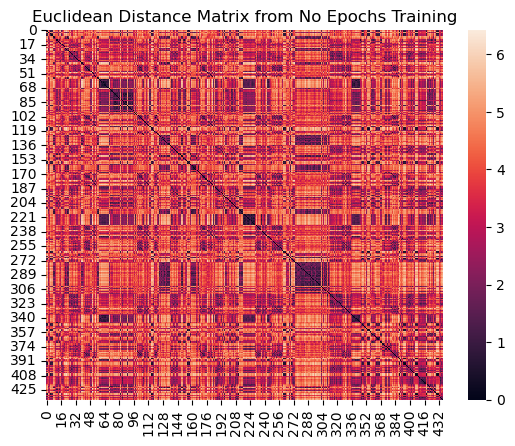

In [13]:
upgma(metric_list[1:2], embedding, writer, out_path, "No","_notraining",activation_function)

print(embedding)

# T-SNE

In [14]:
colour_df = pd.read_csv(inputs+"KLK_iTOL.txt", sep='\t',names=('protein', 'range', 'colour', 'family'))
colour_df = colour_df.drop([0,1,2])

colour_df['family'] = colour_df['family'].replace(['KLK4','KLK5','KLK7'], 'KLK4/5/7',regex = False)
colour_df['family'] = colour_df['family'].replace(['KLK8','KLK10','KLK12'], 'KLK8/10/12',regex = False)
colour_df['family'] = colour_df['family'].replace(['KLK1','Mammalian KLK1','non-mammalian KLK1'], 'KLK1',regex = False)
colour_df['family'] = colour_df['family'].replace(['KLK1','KLK2','Reptilian KLKs'], 'KLK1/2/Reptilian KLK',regex = False)
colour_df['family'] = colour_df['family'].replace(['KLK4/5/7','KLK8/10/12'], 'KLK4/5/7/8/10/12',regex = False)

types = len(colour_df["family"].unique())
print(types)



14


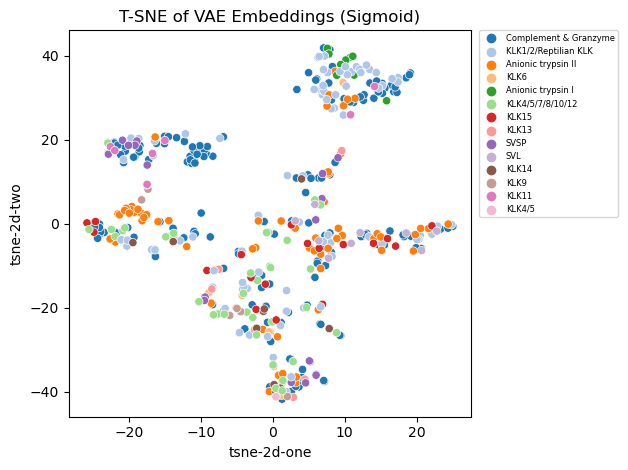

In [15]:
from sklearn.manifold import TSNE

def tsne(embeddings, df_protein_types, title_name, dataset,n_types):
    
    tsne = TSNE(perplexity = 22, learning_rate = 100, n_iter = 1000, random_state= 42)#(n_components=2, verbose=1, random_state=123)
    tsne_results = tsne.fit_transform(embeddings)

    df_subset = pd.DataFrame()
    df_subset["Type"] = df_protein_types["family"]
    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]

    #print(df_subset)
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Type",
        palette=sns.color_palette("tab20",n_types),
        edgecolor = 'white',
        data=df_subset,
        legend="full"
    ).set(title= title_name)

    plt.legend(bbox_to_anchor=(1.02, 1),loc='upper left', borderaxespad=0,fontsize="6")
    plt.tight_layout()
    plt.savefig(out_path+'tsne_'+dataset+'.png', dpi=600)
    
    return tsne_results


tsne_results_trained = tsne(embedding_out,colour_df, f"T-SNE of VAE Embeddings ({activation_function.capitalize()})", f"{activation_function}_trained",types)


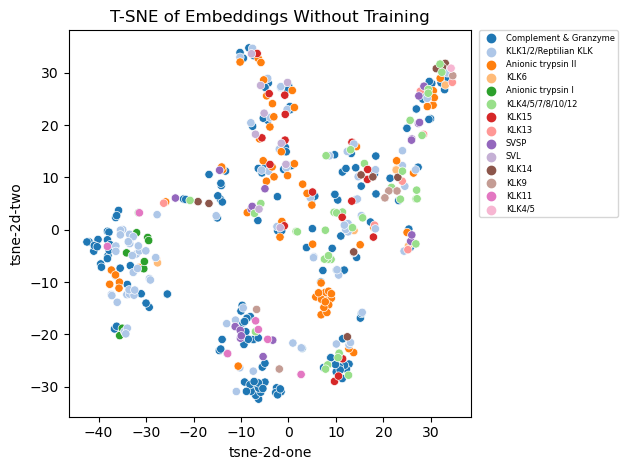

In [16]:
tsne_results_ref = tsne(embedding,colour_df, "T-SNE of Embeddings Without Training","reference",types)

(437, 2)
manhattan
trustworthiness:  0.9904921672896461


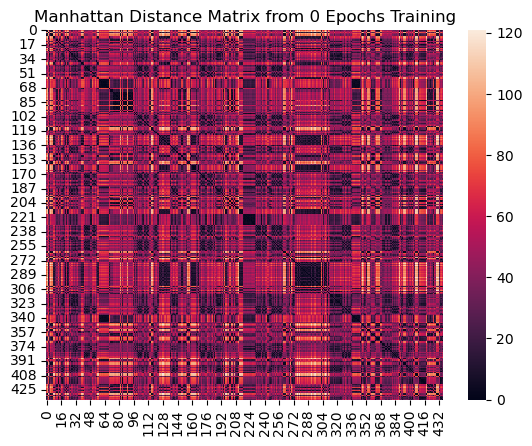

In [31]:
print(tsne_results_trained.shape)
nj(metric_list[2:3], tsne_results_ref, True, out_path, "0", "_tsne",activation_function)
#upgma(metric_list[1:2],  tsne_results_ref, True, out_path, "0", "_tsne", activation_function)


# PCA

Explained variation per principal component: [0.34267048 0.28678208]


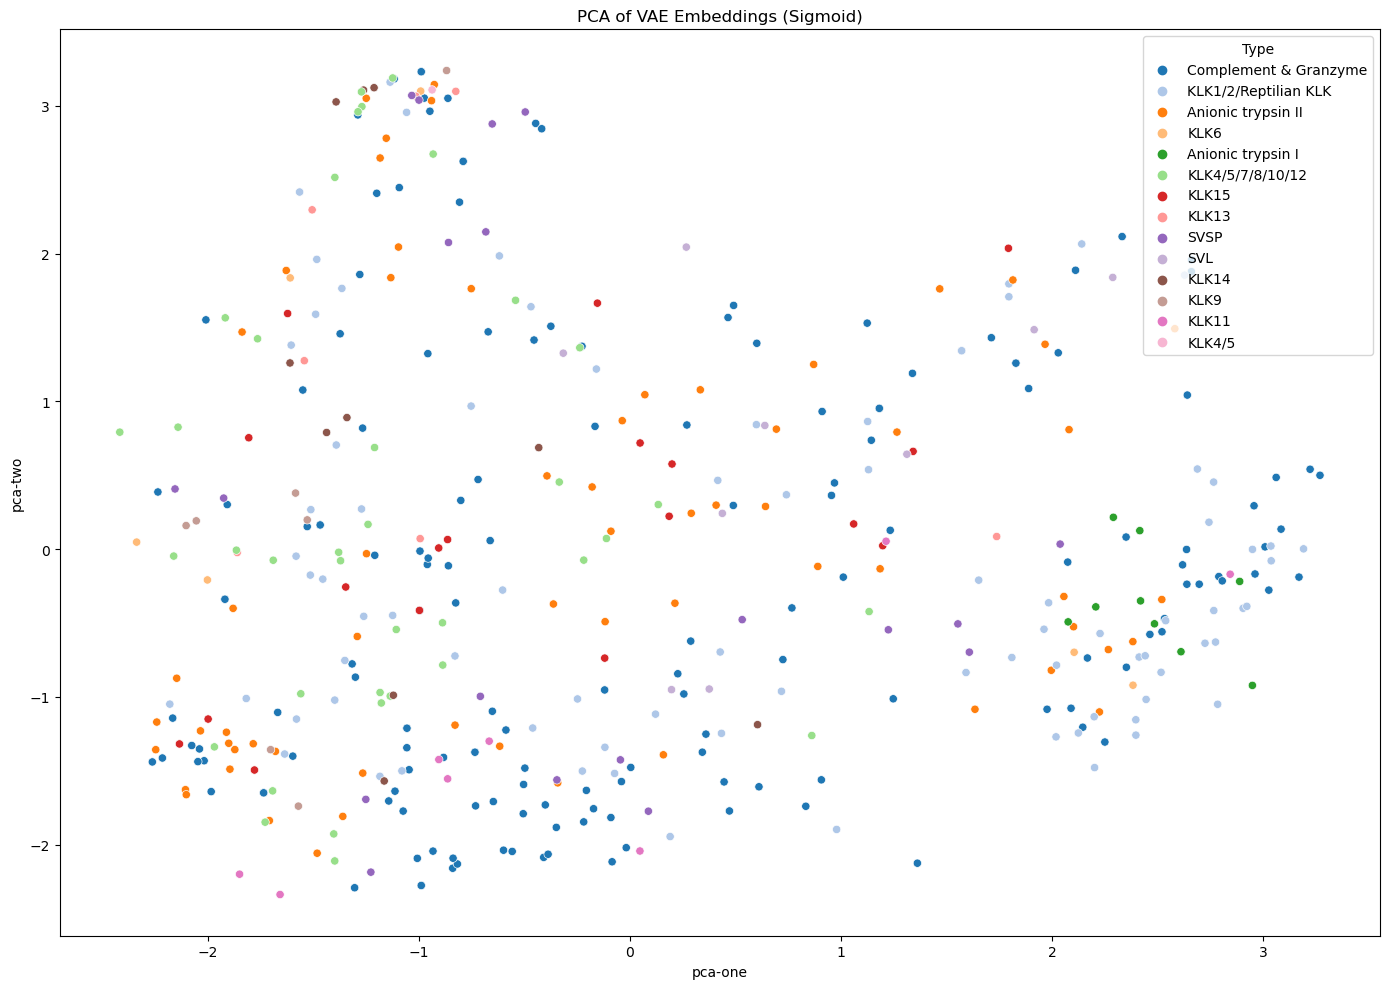

In [18]:
from sklearn.decomposition import PCA

def pca(embeddings, df_protein_types, title_name, dataset,n_types):
    
    pca = PCA(n_components=2,random_state=42)
    pca_result = pca.fit_transform(embeddings)

    df = pd.DataFrame()
    df["Type"] = colour_df["family"]
    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1] 
    #df['pca-three'] = pca_result[:,2]
    print()

    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


    plt.figure(figsize=(14,10))
    sns.scatterplot(
        x="pca-one", y="pca-two",
        hue="Type",
        palette=sns.color_palette("tab20", n_types),
        data=df,
        legend="full").set(title= title_name)
    
    plt.tight_layout()
    plt.savefig(out_path+'pca_'+dataset+'.png', dpi=600)
    
    return pca_result




pca_results_trained = pca(embedding_out, colour_df, f"PCA of VAE Embeddings ({activation_function.capitalize()})", f"{activation_function}_trained",types)


Explained variation per principal component: [0.3488471  0.15480681]


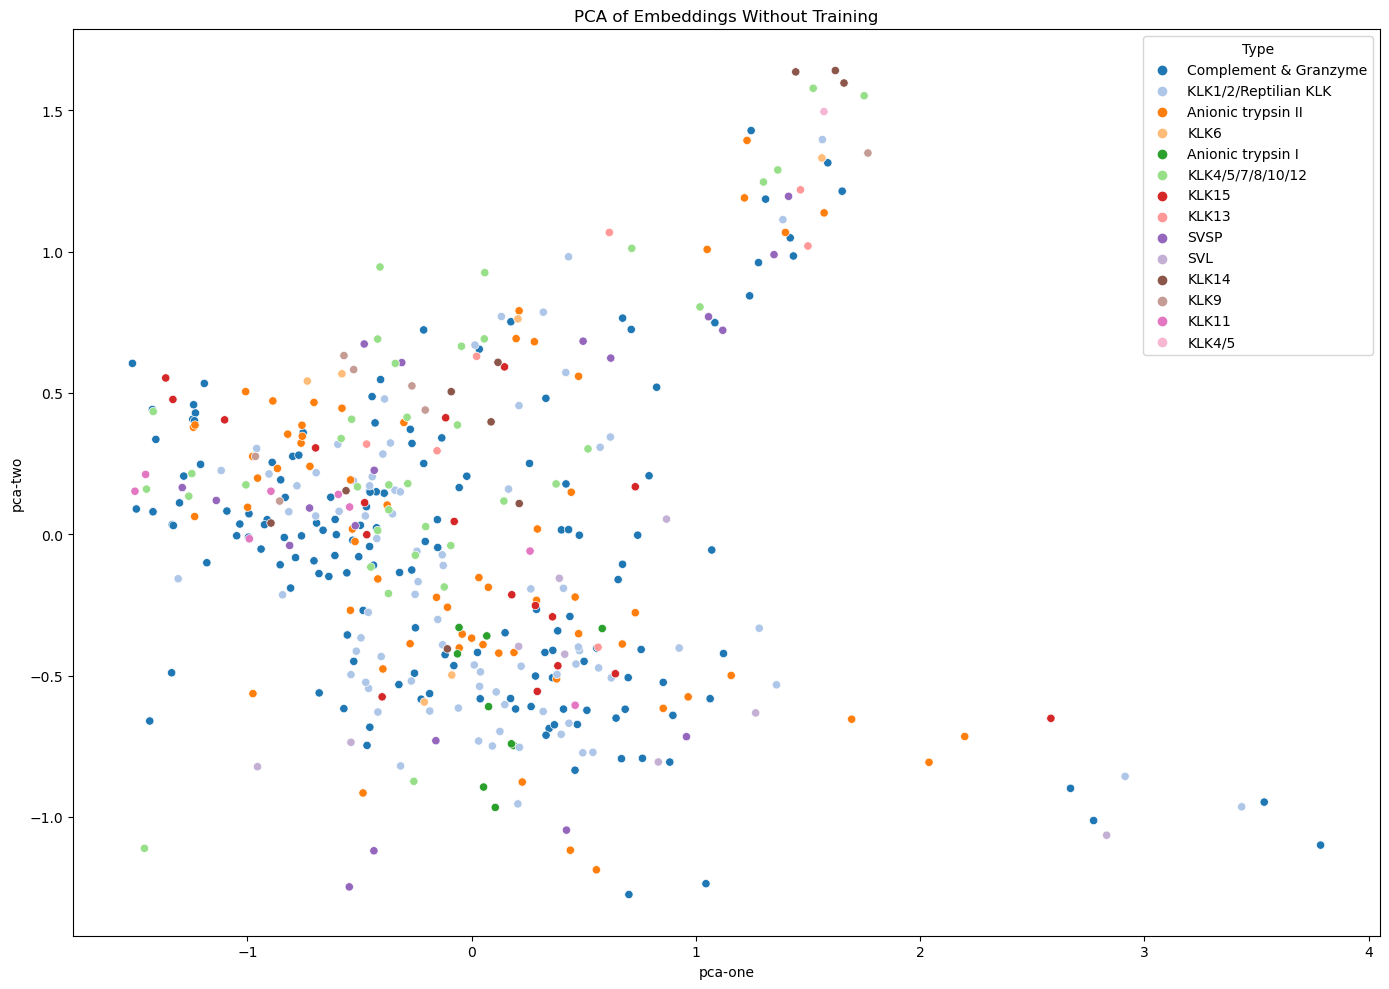

In [21]:
pca_results_reference = pca(embedding, colour_df,  f"PCA of Embeddings Without Training", "reference",types)

(437, 2)
epoch: 0
metric: ts_ss
trustworthiness:  0.9773246360524551


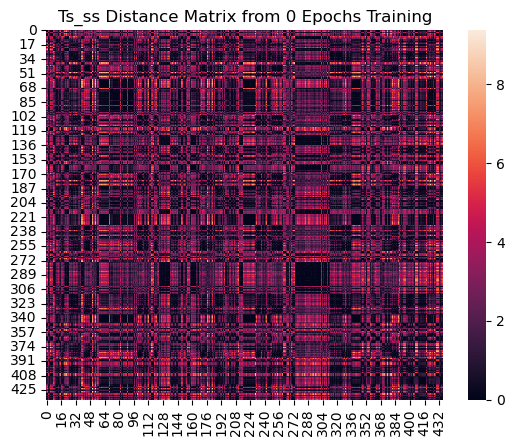

In [30]:
print(pca_results_trained.shape)
#nj(metric_list[1:2], pca_results_reference, True, out_path, "0", "_pca",activation_function)
#upgma(metric_list[3:4],  pca_results_reference, True, out_path, "0", "_pca", activation_function)